# Optical Flow with FlowNet on KITTI Dataset

Notebook for computing optical flow using pretrained FlowNet models.

**Dataset**: KITTI 2011_09_28_drive_0038_sync (110 frames)  
**Model**: FlowNetS (pretrained)  
**Task**: Compute optical flow between consecutive frames

## 1. Imports and Setup

In [79]:
# Standard libraries
import sys
import os
import time
from pathlib import Path
import glob

# Data processing
import numpy as np
import pandas as pd

# Image processing
import cv2

# Deep learning
import torch
import torch.nn.functional as F

# Visualization
import matplotlib.pyplot as plt
from tqdm import tqdm

print("✓ All imports successful")

✓ All imports successful


## 1.5. Download FlowNetPytorch Repository

In [92]:
import os

# Clone FlowNetPytorch repository if it doesn't exist
flownet_path = '/kaggle/working/FlowNetPytorch'

if not os.path.exists(flownet_path):
    print("Cloning FlowNetPytorch repository...")
    # Change to working directory first
    !cd /kaggle/working && git clone https://github.com/ClementPinard/FlowNetPytorch.git
    
    if os.path.exists(flownet_path):
        print("✓ Repository cloned successfully")
    else:
        print("⚠ Clone may have failed, but continuing...")
else:
    print("✓ FlowNetPytorch already exists")

# Add to Python path
if flownet_path not in sys.path:
    sys.path.insert(0, flownet_path)
    
print(f"✓ Added FlowNetPytorch to path: {flownet_path}")

# Verify the repository structure
if os.path.exists(flownet_path):
    print("\nRepository contents:")
    !ls -la /kaggle/working/FlowNetPytorch | head -15


Cloning FlowNetPytorch repository...
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
chdir: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
Cloning into 'FlowNetPytorch'...
remote: Enumerating objects: 559, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 559 (delta 150), reused 137 (delta 137), pack-reused 355 (from 1)
Receiving objects: 100% (559/559), 1.21 MiB | 10.70 MiB/s, done.
Resolving deltas: 100% (328/328), done.
✓ Repository cloned successfully
✓ Added FlowNetPytorch to path: /kaggle/working/FlowNetPytorch

Repository contents:
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
total 88
drwxr-xr-x 6 root root  4096 Nov 11 07:41 .
drwxr-xr-x 5 root root  4096 Nov 11 07:41 ..
drwxr-xr-x 2 root root  4096 Nov 11 07:41 dataset

## 2. Check GPU

In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("=" * 60)
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("✗ Using CPU")
print("=" * 60)

✓ GPU: Tesla T4
  Memory: 15.83 GB


## 3. Load KITTI Dataset

In [109]:
# Dataset path
base_dir = Path('/kaggle/input/flownet/2011_09_28/2011_09_28_drive_0038_sync')

# Load image paths
image_paths = sorted(glob.glob(str(base_dir / 'image_02' / 'data' / '*.png')))

# Load timestamps
with open(base_dir / 'image_02' / 'timestamps.txt', 'r') as f:
    timestamps = [line.strip() for line in f.readlines()]

# Create DataFrame
df = pd.DataFrame({
    'frame_id': range(len(image_paths)),
    'timestamp': pd.to_datetime(timestamps),
    'image_path': image_paths
})

print(f"✓ Loaded {len(df)} frames")
print(f"  Duration: {df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]}")
df.head()

✓ Loaded 110 frames
  Duration: 0 days 00:00:11.293573888


frame_id                     timestamp  \
0         0 2011-09-28 12:47:21.706846720   
1         1 2011-09-28 12:47:21.810363904   
2         2 2011-09-28 12:47:21.914002688   
3         3 2011-09-28 12:47:22.017637120   
4         4 2011-09-28 12:47:22.121276672   

                                          image_path  
0  /kaggle/input/flownet/2011_09_28/2011_09_28_dr...  
1  /kaggle/input/flownet/2011_09_28/2011_09_28_dr...  
2  /kaggle/input/flownet/2011_09_28/2011_09_28_dr...  
3  /kaggle/input/flownet/2011_09_28/2011_09_28_dr...  
4  /kaggle/input/flownet/2011_09_28/2011_09_28_dr...

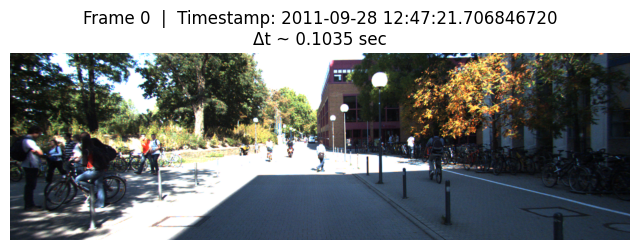

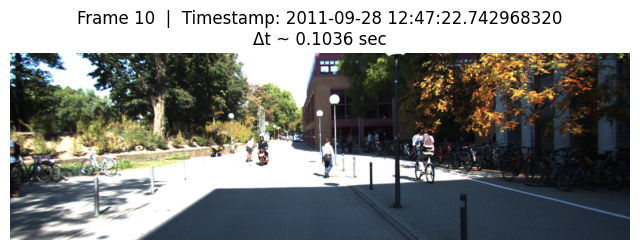

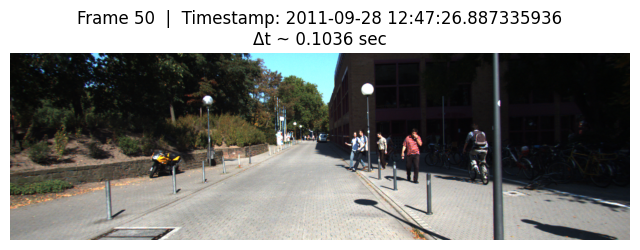

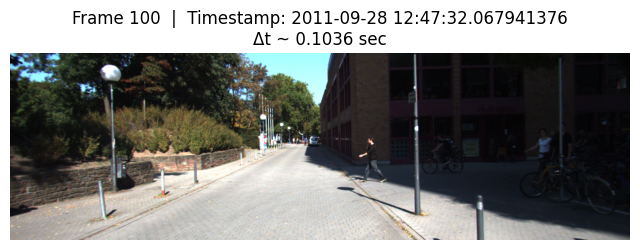

In [110]:
import matplotlib.pyplot as plt

def show_sample_and_velocity(df, idx):
    """
    Visualizes a sample image and its associated 'velocity'.
    Args:
        df: DataFrame with ['frame_id', 'timestamp', 'image_path']
        idx: Index (int) of sample to show
    """
    img_path = df.iloc[idx]['image_path']
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Compute 'velocity' based on time difference between consecutive frames
    if 0 < idx < len(df)-1:
        t_prev = df.iloc[idx-1]['timestamp']
        t_next = df.iloc[idx+1]['timestamp']
        dt = (t_next - t_prev).total_seconds() / 2
    elif idx == 0 and len(df) > 1:
        dt = (df.iloc[1]['timestamp'] - df.iloc[0]['timestamp']).total_seconds()
    else:
        dt = None

    # Show image
    plt.figure(figsize=(8,4))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Frame {df.iloc[idx]['frame_id']}  |  Timestamp: {df.iloc[idx]['timestamp']}\n"
              + (f"Δt ~ {dt:.4f} sec" if dt is not None else "No Δt"))
    plt.show()

# Example: Visualize a few samples and 'velocities'
for i in [0, 10, 50, 100]:
    if i < len(df):
        show_sample_and_velocity(df, i)


## 4. Load FlowNet Model

In [111]:
!tree /kaggle/input/flownet-model/

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
/kaggle/input/flownet-model/
└── pytorch
    └── default
        └── 1
            └── FlowNet Models
                ├── FlyingChairs_release.list
                ├── pytorch
                │   ├── flownetc_EPE1.766.pth
                │   ├── flownets_bn_EPE2.459.pth
                │   ├── flownets_EPE1.951.pth
                │   └── flownets_from_caffe.pth
                └── torch
                    ├── DispNet.t7
                    ├── FlowNetSBN_from_scratch.t7
                    ├── flowNetS_smalldisp.t7
                    └── flowNetS.t7

6 directories, 9 files


In [112]:
# Setup path and imports
import os
import sys
import importlib.util

flownet_path = '/kaggle/working/FlowNetPytorch'

# Debug: Check current state
print(f"FlowNet path exists: {os.path.exists(flownet_path)}")
print(f"models dir exists: {os.path.exists(os.path.join(flownet_path, 'models'))}")
print(f"util.py exists: {os.path.exists(os.path.join(flownet_path, 'util.py'))}")

# Force add to beginning of sys.path
if flownet_path in sys.path:
    sys.path.remove(flownet_path)
sys.path.insert(0, flownet_path)
print(f"✓ Path added. First 3 sys.path entries: {sys.path[:3]}")

# Clear any cached imports
for mod in ['models', 'util', 'models.FlowNetS', 'models.FlowNetC']:
    if mod in sys.modules:
        del sys.modules[mod]

# Try importing with better error handling
try:
    import models
    print(f"✓ models imported from: {models.__file__}")
except ModuleNotFoundError as e:
    print(f"❌ Failed to import models: {e}")
    print("\nTrying manual import...")
    # Manual workaround: load the module directly
    spec = importlib.util.spec_from_file_location("models", os.path.join(flownet_path, "models", "__init__.py"))
    models = importlib.util.module_from_spec(spec)
    sys.modules['models'] = models
    spec.loader.exec_module(models)
    print(f"✓ models loaded manually")

try:
    from util import flow2rgb
    print(f"✓ util imported successfully")
except ImportError as e:
    print(f"❌ Failed to import util: {e}")
    print("\nTrying manual import...")
    spec = importlib.util.spec_from_file_location("util", os.path.join(flownet_path, "util.py"))
    util = importlib.util.module_from_spec(spec)
    sys.modules['util'] = util
    spec.loader.exec_module(util)
    flow2rgb = util.flow2rgb
    print(f"✓ util loaded manually")

print("\n✓ All imports successful")

# Load checkpoint
model_path = '/kaggle/input/flownet-model/pytorch/default/1/FlowNet Models/pytorch/flownets_EPE1.951.pth'
network_data = torch.load(model_path, map_location=device)

print("\nLoading FlowNetS...")
print(f"Architecture: {network_data.get('arch', 'flownets')}")
print(f"Epoch: {network_data.get('epoch', 'N/A')}, EPE: {network_data.get('best_EPE', 'N/A'):.4f}")

# Get div_flow for scaling
div_flow = network_data.get('div_flow', 20.0)
print(f"div_flow: {div_flow}")

# Create model using the proper factory function
model = models.flownets(network_data).to(device)
model.eval()

print(f"\n✓ Model loaded successfully")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

FlowNet path exists: True
models dir exists: True
util.py exists: True
✓ Path added. First 3 sys.path entries: ['/kaggle/working/FlowNetPytorch', '/kaggle/working/FlowNetPytorch', '/Users/aldajo92mac/ParkingRandom/FlowNetPytorch']
❌ Failed to import models: No module named 'models'

Trying manual import...
✓ models loaded manually
❌ Failed to import util: No module named 'util'

Trying manual import...
✓ util loaded manually

✓ All imports successful

Loading FlowNetS...
Architecture: flownets
Epoch: 297, EPE: 1.9474
div_flow: 20.0

✓ Model loaded successfully
  Parameters: 38,675,536


## 5. Inference Functions

In [113]:
def compute_flow(model, img1, img2, device, div_flow=20.0):
    """Compute optical flow using FlowNetPytorch (ClementPinard implementation)."""
    with torch.no_grad():
        h, w = img1.shape[:2]
        
        # Pad to multiple of 64
        h_pad = ((h - 1) // 64 + 1) * 64
        w_pad = ((w - 1) // 64 + 1) * 64
        
        # Resize
        img1_r = cv2.resize(img1, (w_pad, h_pad))
        img2_r = cv2.resize(img2, (w_pad, h_pad))
        
        # Preprocess: BGR to RGB
        img1_rgb = cv2.cvtColor(img1_r, cv2.COLOR_BGR2RGB).astype(np.float32)
        img2_rgb = cv2.cvtColor(img2_r, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        # Normalize (following FlowNetPytorch preprocessing)
        # 1. Divide by 255 to get [0, 1]
        # 2. Subtract RGB mean [0.411, 0.432, 0.45]
        mean = np.array([0.411, 0.432, 0.45], dtype=np.float32)
        img1_norm = (img1_rgb / 255.0) - mean
        img2_norm = (img2_rgb / 255.0) - mean
        
        # Stack to [6, H, W]
        img1_tensor = torch.from_numpy(img1_norm.transpose(2, 0, 1))
        img2_tensor = torch.from_numpy(img2_norm.transpose(2, 0, 1))
        input_tensor = torch.cat([img1_tensor, img2_tensor], 0).unsqueeze(0).to(device)
        
        # Compute flow
        output = model(input_tensor)
        
        # Get flow (output is downsampled by 4x)
        flow = output.squeeze().cpu().numpy().transpose(1, 2, 0)
        
        # Multiply by div_flow to get actual pixel displacement
        flow = flow * div_flow
        
        # Upsample to original resolution
        flow = cv2.resize(flow, (w, h))
        
        # Scale flow vectors proportionally
        flow[:, :, 0] *= w / (w_pad / 4)
        flow[:, :, 1] *= h / (h_pad / 4)
    
    return flow

def visualize_flow(flow, max_value=None):
    """
    Convert flow to RGB visualization using the proper flow2rgb from FlowNetPytorch.
    This matches the visualization used in the GT images.
    
    Args:
        flow: [H, W, 2] numpy array
        max_value: optional max flow value for normalization
    
    Returns:
        RGB image [H, W, 3] as uint8
    """
    # Convert from [H, W, 2] to [2, H, W] tensor for flow2rgb
    flow_tensor = torch.from_numpy(flow.transpose(2, 0, 1))
    
    # Use the proper flow2rgb function from FlowNetPytorch
    rgb = flow2rgb(flow_tensor, max_value=max_value)
    
    # Convert from [3, H, W] to [H, W, 3] and scale to 0-255
    rgb_image = (rgb.transpose(1, 2, 0) * 255).astype(np.uint8)
    
    return rgb_image

print("✓ Functions ready")

✓ Functions ready


## 6. Debug: Check Tensor Values


In [114]:
# Quick test to verify preprocessing
img1_test = cv2.imread(df.loc[0, 'image_path'])
img1_rgb = cv2.cvtColor(img1_test, cv2.COLOR_BGR2RGB).astype(np.float32)

# Apply normalization
mean = np.array([0.411, 0.432, 0.45], dtype=np.float32) * 255
img1_norm = (img1_rgb - mean) / 255.0

print(f"Original range: [{img1_rgb.min():.1f}, {img1_rgb.max():.1f}]")
print(f"Mean values: {mean}")
print(f"After normalization: [{img1_norm.min():.3f}, {img1_norm.max():.3f}]")
print(f"✓ Ready for inference")


Original range: [0.0, 255.0]
Mean values: [104.805 110.16  114.75 ]
After normalization: [-0.450, 0.589]
✓ Ready for inference


## 7. Test on Single Frame Pair

In [115]:
# Load first two frames
img1 = cv2.imread(df.loc[0, 'image_path'])
img2 = cv2.imread(df.loc[1, 'image_path'])

print(f"Image shape: {img1.shape}")

# Compute flow (using div_flow from checkpoint)
start = time.time()
flow = compute_flow(model, img1, img2, device, div_flow=div_flow)
print(f"✓ Flow computed in {time.time() - start:.3f}s")

# Stats
mag = np.sqrt(flow[:, :, 0]**2 + flow[:, :, 1]**2)
print(f"  Mean magnitude: {mag.mean():.2f} px")
print(f"  Max magnitude: {mag.max():.2f} px")

Image shape: (370, 1224, 3)
✓ Flow computed in 0.073s
  Mean magnitude: 66.63 px
  Max magnitude: 203.24 px


## 8. Visualize Results

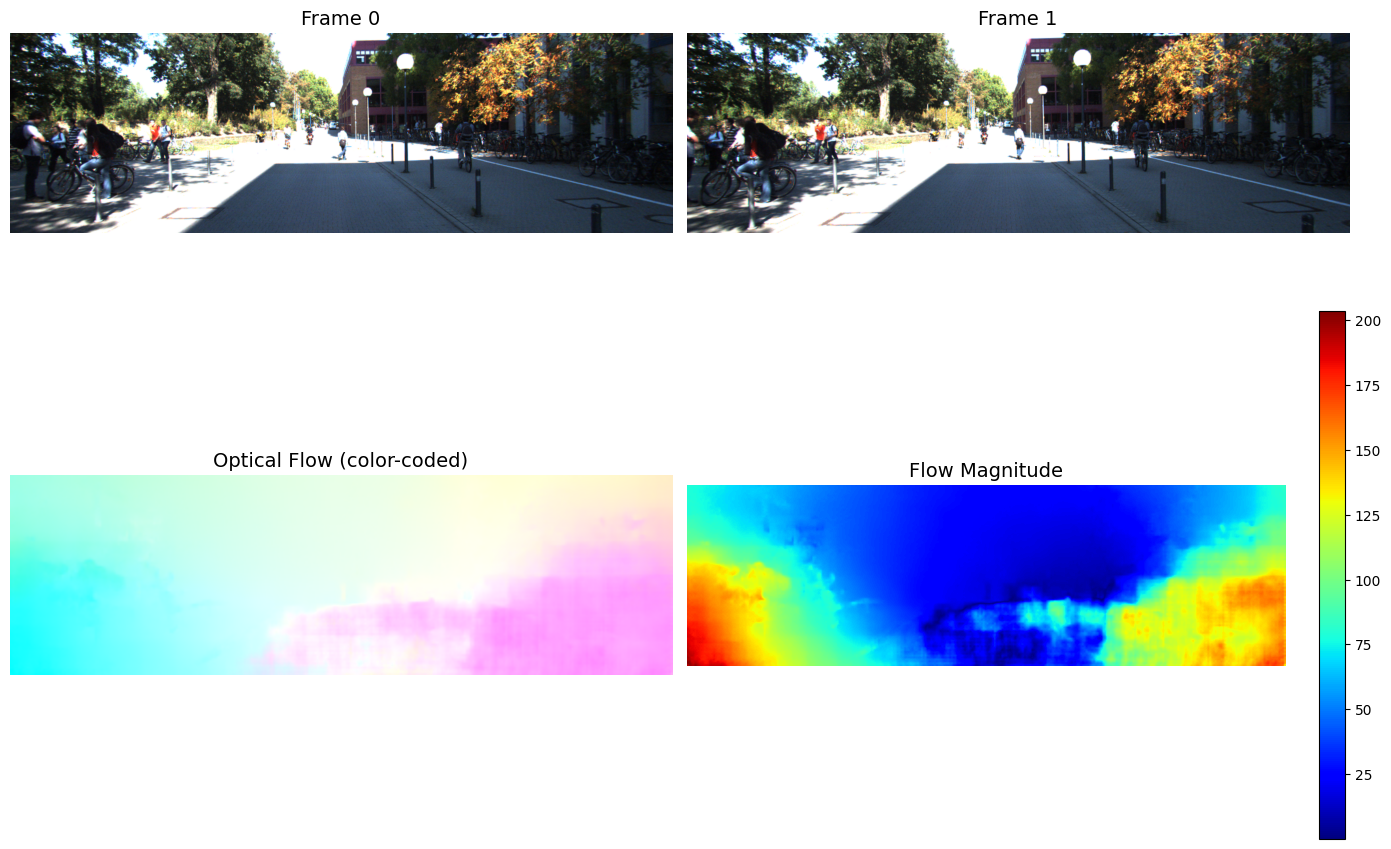

In [116]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original frames
axes[0, 0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Frame 0', fontsize=14)
axes[0, 0].axis('off')

axes[0, 1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title('Frame 1', fontsize=14)
axes[0, 1].axis('off')

# Flow visualization using proper flow2rgb
flow_rgb = visualize_flow(flow, max_value=None)
axes[1, 0].imshow(flow_rgb)
axes[1, 0].set_title('Optical Flow (color-coded)', fontsize=14)
axes[1, 0].axis('off')

im = axes[1, 1].imshow(mag, cmap='jet')
axes[1, 1].set_title('Flow Magnitude', fontsize=14)
axes[1, 1].axis('off')
plt.colorbar(im, ax=axes[1, 1], fraction=0.046)

plt.tight_layout()
plt.show()

## 9. Batch Process Multiple Frames

In [117]:
# Process first 20 frame pairs
n_frames = 20
flows = []
stats = []

print(f"Processing {n_frames} frame pairs...")
for i in tqdm(range(n_frames)):
    img1 = cv2.imread(df.loc[i, 'image_path'])
    img2 = cv2.imread(df.loc[i + 1, 'image_path'])
    
    flow = compute_flow(model, img1, img2, device, div_flow=div_flow)
    flows.append(flow)
    
    mag = np.sqrt(flow[:, :, 0]**2 + flow[:, :, 1]**2)
    stats.append({'mean': mag.mean(), 'max': mag.max()})

stats_df = pd.DataFrame(stats)
print(f"\n✓ Computed {len(flows)} flows")
print(f"\nStatistics:")
print(stats_df.describe())

Processing 20 frame pairs...


100%|██████████| 20/20 [00:01<00:00, 10.75it/s]


✓ Computed 20 flows

Statistics:
            mean         max
count  20.000000   20.000000
mean   56.734364  172.975891
std     4.591499   12.260995
min    50.643482  153.919006
25%    53.693316  166.756737
50%    55.513407  172.546387
75%    59.507462  179.238510
max    66.630157  203.242371


## 10. Visualize Flow Sequence

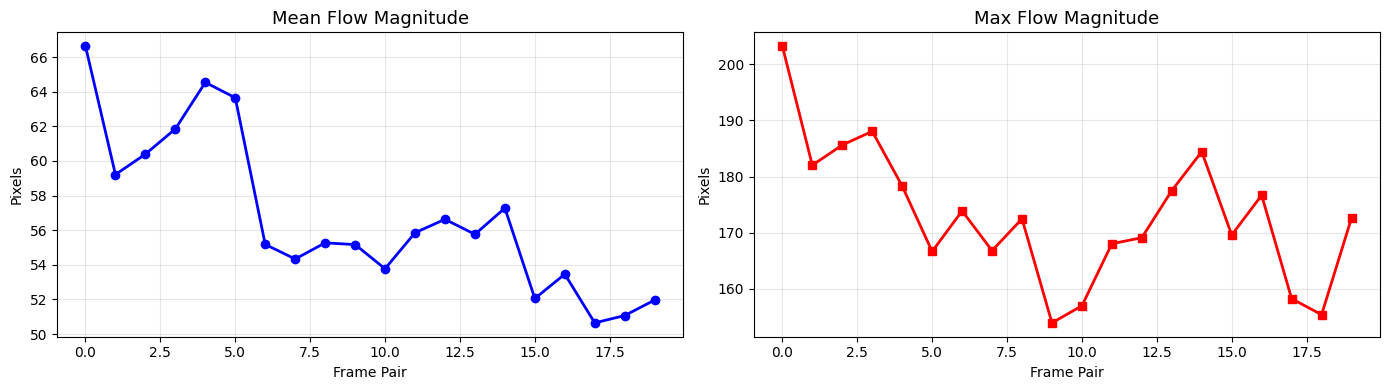

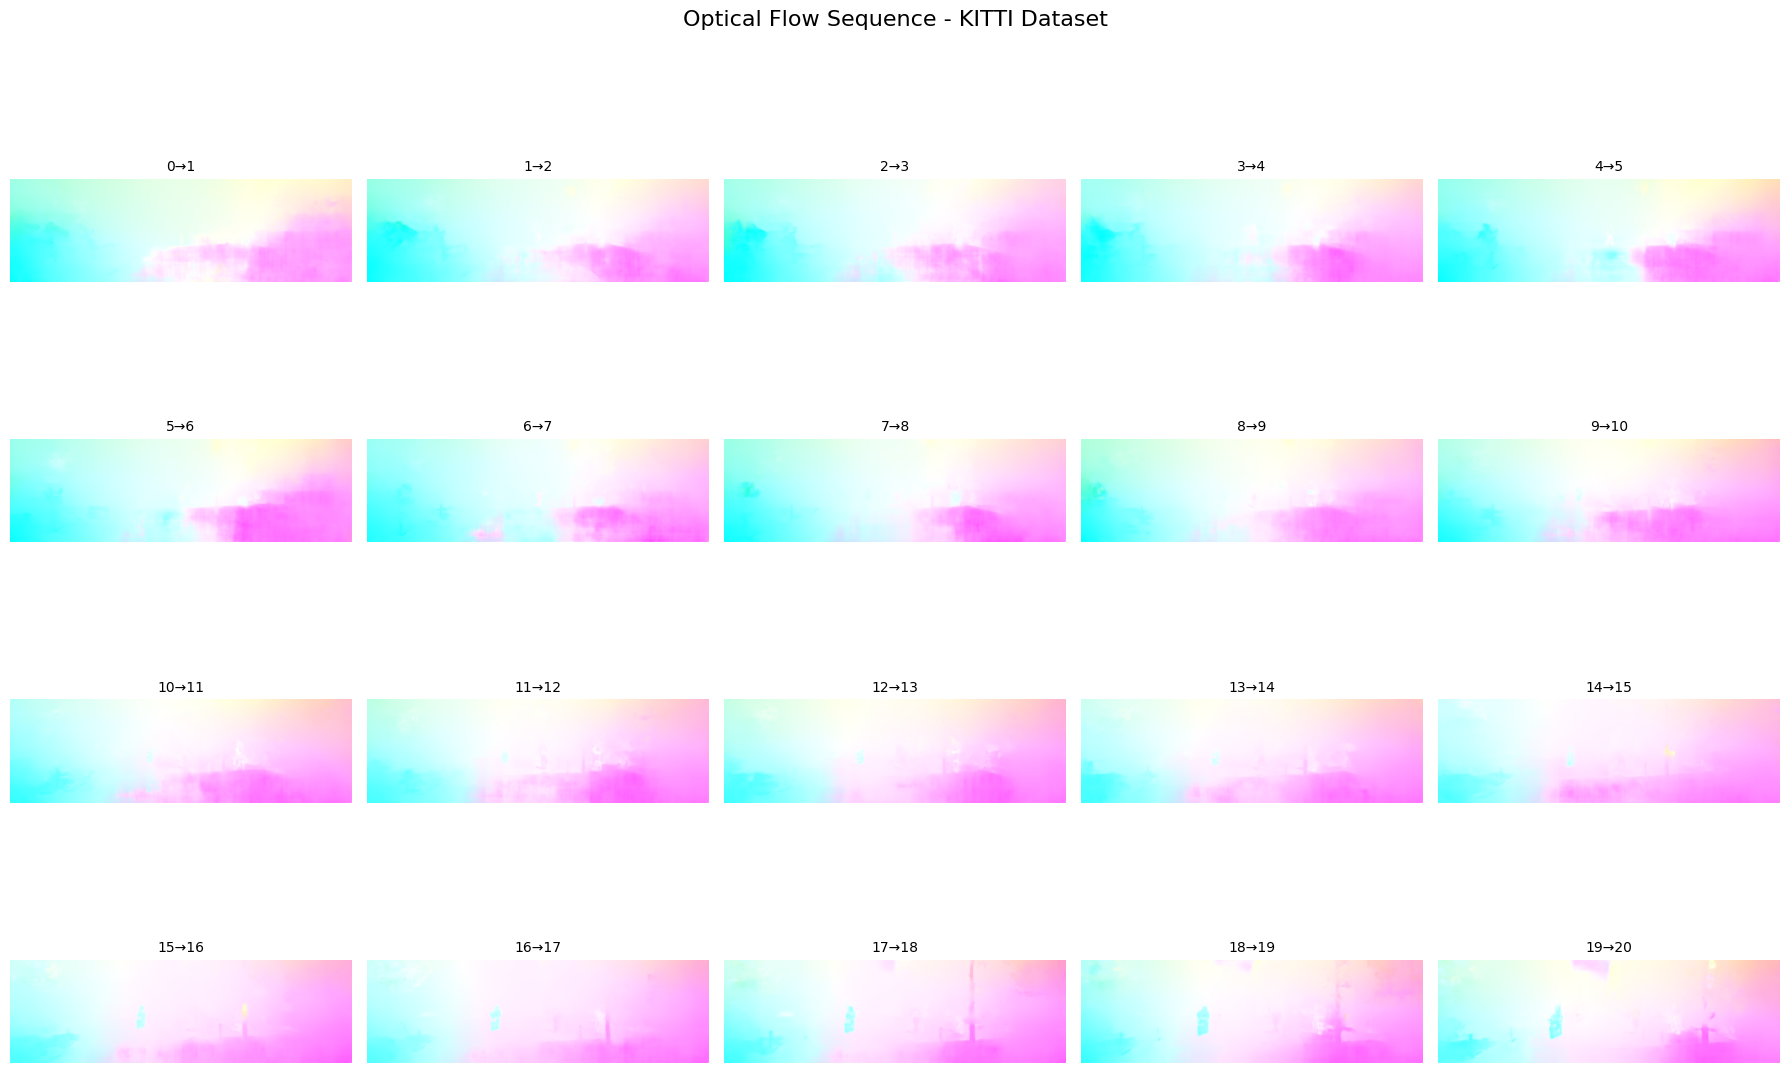

In [118]:
# Plot statistics
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(stats_df['mean'], 'b-o', linewidth=2)
axes[0].set_title('Mean Flow Magnitude', fontsize=13)
axes[0].set_xlabel('Frame Pair')
axes[0].set_ylabel('Pixels')
axes[0].grid(True, alpha=0.3)

axes[1].plot(stats_df['max'], 'r-s', linewidth=2)
axes[1].set_title('Max Flow Magnitude', fontsize=13)
axes[1].set_xlabel('Frame Pair')
axes[1].set_ylabel('Pixels')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show flow grid using proper flow2rgb
fig, axes = plt.subplots(4, 5, figsize=(18, 12))
axes = axes.flatten()

for i in range(min(20, len(flows))):
    flow_rgb = visualize_flow(flows[i], max_value=None)
    axes[i].imshow(flow_rgb)
    axes[i].set_title(f'{i}→{i+1}', fontsize=10)
    axes[i].axis('off')

plt.suptitle('Optical Flow Sequence - KITTI Dataset', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

## 11. Save Results (Optional)

In [119]:
# Save flow in standard .flo format
output_dir = Path('/kaggle/working/flow_results')
output_dir.mkdir(exist_ok=True)

# Save first flow
def save_flo(flow, filename):
    with open(filename, 'wb') as f:
        f.write(b'PIEH')
        np.array([flow.shape[1], flow.shape[0]], dtype=np.int32).tofile(f)
        flow.astype(np.float32).tofile(f)

save_flo(flows[0], output_dir / 'flow_000.flo')
stats_df.to_csv(output_dir / 'statistics.csv', index=False)

print(f"✓ Saved to {output_dir}")

✓ Saved to /kaggle/working/flow_results


## 12. Visualize Flow with Arrows


Visualizing optical flow with arrows...


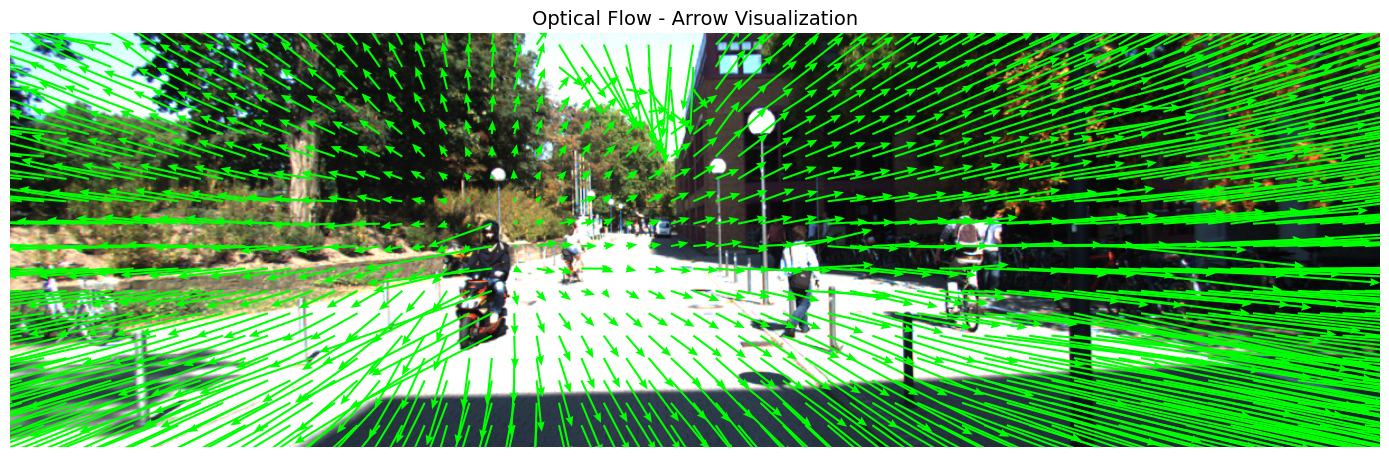

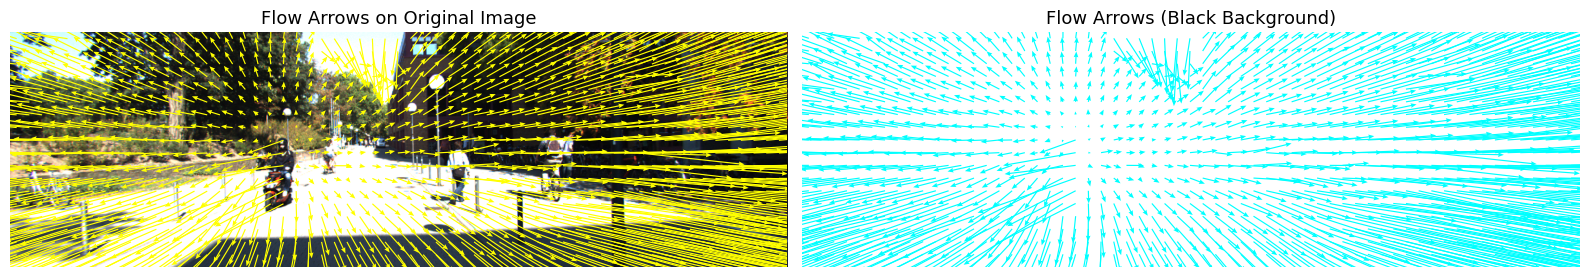

✓ Arrow visualization complete


In [121]:
def visualize_flow_arrows(img, flow, step=16, scale=1.0, arrow_color='yellow'):
    """
    Visualize optical flow as arrows overlaid on the image.
    
    Args:
        img: Background image (BGR format from cv2)
        flow: Flow field [H, W, 2]
        step: Arrow spacing (sample every N pixels)
        scale: Arrow length scale factor
        arrow_color: Color of arrows ('yellow', 'red', 'white', etc.)
    """
    h, w = flow.shape[:2]
    
    # Create meshgrid for arrow positions
    y, x = np.mgrid[step//2:h:step, step//2:w:step].reshape(2, -1).astype(int)
    
    # Get flow vectors at sampled positions
    fx, fy = flow[y, x].T
    
    # Convert image to RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.imshow(img_rgb)
    
    # Plot arrows (quiver plot)
    ax.quiver(x, y, fx, fy, 
              angles='xy', scale_units='xy', scale=1/scale,
              color=arrow_color, width=0.0015, headwidth=4, headlength=5)
    
    ax.set_title('Optical Flow - Arrow Visualization', fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize first frame with flow arrows
print("Visualizing optical flow with arrows...")
visualize_flow_arrows(img1, flow, step=20, scale=2.0, arrow_color='lime')

# Alternative: Show arrows on darker background for better visibility
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Original with arrows
h, w = flow.shape[:2]
y, x = np.mgrid[10:h:20, 10:w:20].reshape(2, -1).astype(int)
fx, fy = flow[y, x].T
img_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
axes[0].imshow(img_rgb)
axes[0].quiver(x, y, fx, fy, angles='xy', scale_units='xy', scale=0.5,
               color='yellow', width=0.0015, headwidth=4, headlength=5)
axes[0].set_title('Flow Arrows on Original Image', fontsize=13)
axes[0].axis('off')

# Right: Arrows on black background (clearer visualization)
axes[1].set_facecolor('black')
axes[1].quiver(x, y, fx, fy, angles='xy', scale_units='xy', scale=0.5,
               color='cyan', width=0.0015, headwidth=4, headlength=5)
axes[1].set_xlim(0, w)
axes[1].set_ylim(h, 0)  # Invert y-axis to match image coordinates
axes[1].set_title('Flow Arrows (Black Background)', fontsize=13)
axes[1].set_aspect('equal')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("✓ Arrow visualization complete")
